In [1]:
# ipynb形式のライブラリのインポート
%run ./lib/lib.ipynb

# 生データの入ったCSVファイルの保持されたディレクトリ名を格納している変数
csvDirPath = "./csv_files/"
benchmarkNames = ["cg", "ep", "ft", "is", "lu", "mg"]

DEBUG:__main__:hello


In [2]:
# ipynb形式のライブラリノートを.py形式に変更したものをインポート
import lib
import lib.lab_lib
from lib.lab_lib import *

DEBUG:lib.lab_lib:hello


# 2022年3月22日～

ベンチマークプログラムCGの関数 `VECSET` において、回帰木モデルのチューニングをする

## ✅TODOs

1. ✅VECSETだけのMAPE表を作る
2. ✅githubのissueにある「やること群」をリストアップする

## TODOs２

* 木を出力して確認する
* ノードに含まれるサンプル数のパラメータを確認
* 毎回結果が異なるかもしれないのでそれを固定する＠ハイパーパラメータ
* 入力データがすべて数値データなのを確認
* 交差検証をする（一つのデータをテスト対象にする。すべてのデータをテスト対象とした結果をまとめる。）

In [3]:
import graphviz
from sklearn.model_selection import cross_val_score

DEBUG:graphviz._tools:deprecate positional args: graphviz.backend.piping.pipe(['renderer', 'formatter', 'quiet'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.backend.rendering.render(['renderer', 'formatter', 'quiet'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.backend.unflattening.unflatten(['stagger', 'fanout', 'chain', 'encoding'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.backend.viewing.view(['quiet'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.quoting.quote(['is_html_string', 'is_valid_id', 'dot_keywords', 'escape_unescaped_quotes'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.quoting.a_list(['kwargs', 'attributes'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.quoting.attr_list(['kwargs', 'attributes'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.dot.Dot.clear(['keep_attrs'])
DEBUG:graphviz._tools:deprecate positional args: graphviz.dot.Dot.__iter__(['subgraph'])
DEBUG:graphviz._

In [4]:


benchmark_name = "cg"

classes = ["A", "B", "C", "D", "E", "F"]
processes = [2, 4, 8, 16, 32, 64, 128, 256]


date: str = "2022年3月23日"

# コア数と問題サイズの両方を振る

rawDF: pd.DataFrame = return_rawDF_with_init_param(
    benchmark_name=benchmark_name,
    classes=classes,
    processes=processes,
    csv_dir_path="./csv_files/",
)

# 関数VECSETのみを抽出
functionName: str = "VECSET"
rawDF: pd.DataFrame = rawDF[rawDF["functionName"] == functionName]

exp_var: list[str] = rawDF.columns.tolist()
for element_be_removed in [
    "functionName",
    "functionCallNum",
    "intBenchmarkClass",
    "benchmarkName",
    "benchmarkClass",
]:
    exp_var.remove(element_be_removed)
res_var: list[str] = ["functionCallNum"]

df_exp_var: pd.DataFrame = rawDF.filter(items=exp_var)
df_res_var: pd.DataFrame = rawDF.filter(items=res_var)

ndarray_exp_var: np.ndarray = df_exp_var.values
ndarray_res_var: np.ndarray = df_res_var.values

reg_tree = DecisionTreeRegressor(max_leaf_nodes=5, random_state=0)
model_tree: DecisionTreeRegressor = reg_tree.fit(ndarray_exp_var, ndarray_res_var)

print(f"exp_var = {exp_var}")
print(f"rawDF.info() = {rawDF.info()}")

exp_var = ['process', 'na', 'nonzer', 'niter', 'shift']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 12 to 10
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   functionName       37 non-null     object 
 1   functionCallNum    37 non-null     float64
 2   benchmarkName      37 non-null     object 
 3   benchmarkClass     37 non-null     object 
 4   process            37 non-null     int64  
 5   intBenchmarkClass  37 non-null     int64  
 6   na                 37 non-null     int64  
 7   nonzer             37 non-null     int64  
 8   niter              37 non-null     int64  
 9   shift              37 non-null     int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 3.2+ KB
rawDF.info() = None


DEBUG:graphviz.backend.execute:run [PosixPath('dot'), '-Kdot', '-Tsvg']


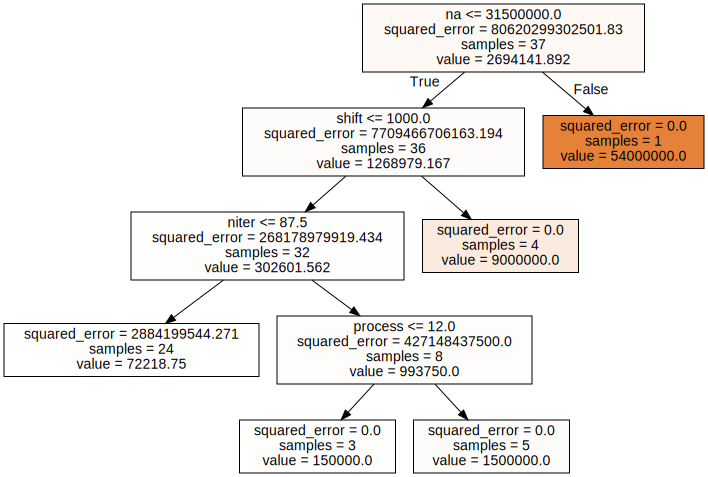

In [5]:
# GraphVizを用いた方法

graph = graphviz.Source(
    tree.export_graphviz(model_tree, feature_names=exp_var, filled=True)
)
graph

In [6]:
# GridSearchCVを用いてグリッドサーチ・交差検証をしてみる

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import tree


X = ndarray_exp_var
Y = ndarray_res_var

train_X, test_X, train_Y, test_Y = train_test_split(
    X,
    Y,
    test_size=0.3,
    shuffle=True,
    random_state=0
)

param = {
    "max_depth":[1,2,3,4],
    "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
    "min_samples_split":[2,3,4,5]
}

# 決定木による学習
clf = GridSearchCV(tree.DecisionTreeRegressor(),param)
clf.fit(ndarray_exp_var, ndarray_res_var)

best_clf = clf.best_estimator_
print(f"最良条件\n{best_clf}")
print(f"訓練スコア\n{best_clf.score(ndarray_exp_var, ndarray_res_var)}")
print(f"テストスコア\n{best_clf.score(ndarray_exp_var, ndarray_res_var)}")

最良条件
DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
訓練スコア
0.4557624322813869
テストスコア
0.4557624322813869


In [7]:
%reset -f

from sklearn import datasets
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import tree
import pandas as pd

iris = datasets.load_iris()
X = pd.DataFrame(iris.data[:, [0, 1, 2, 3]])
Y = pd.Series(iris.target)

train_X, test_X, train_Y, test_Y = train_test_split(
    X,
    Y,
    test_size=0.3,
    shuffle=True,
    random_state=0
)

param = {
    "max_depth":[1,2,3,4,5],
    "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
    "min_samples_split":[2,3,4,5]
}

clf = GridSearchCV(
    tree.DecisionTreeClassifier(),
    param,
    cv=5,
)
clf.fit(train_X, train_Y)

scores = clf.cv_results_["mean_test_score"]
params = clf.cv_results_["params"]

best_clf = clf.best_estimator_
print(f"裁量条件\n{best_clf}")
print(f"訓練スコア\n{best_clf.score(train_X, train_Y)}")
print(f"テストスコア\n{best_clf.score(test_X, test_Y)}")
for i in range(len(scores)):
    print(scores[i], params[i])


裁量条件
DecisionTreeClassifier(max_depth=4, min_samples_split=5)
訓練スコア
0.9809523809523809
テストスコア
0.9777777777777777
0.6952380952380952 {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
0.6952380952380952 {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 3}
0.6952380952380952 {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 4}
0.6952380952380952 {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 5}
0.6952380952380952 {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.6952380952380952 {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 3}
0.6952380952380952 {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 4}
0.6952380952380952 {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.6952380952380952 {'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 2}
0.6952380952380952 {'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 3}
0.6952380952380952 {'max_depth': 1, 'min_samples_leaf': 3